In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

# Import Seasonal Data

In [2]:
df_seas1 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_11_12.csv')
df_seas2 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_12_13.csv')
df_seas3 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_13_14.csv')
df_seas4 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_14_15.csv')
df_seas5 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_15_16.csv')

In [3]:
seas_list = [df_seas1, df_seas2, df_seas3, df_seas4, df_seas5]

In [4]:
for season in seas_list:
    if type(season.day_of_week) != int:
        season_list = day_of_week_col(season)

In [5]:
df_seas5.tail()

,away_WP,to_WP,day_of_week,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot
date,,,,,,,,,,,,,,,,
2016-04-22,NaN,NaN,4,NaN,1.4,63.5,67.0,6.5,48.5,279.7,9.8,2.8,4.2,5.6,7,8.4
2016-04-23,NaN,NaN,5,NaN,1.4,76.5,105.5,9.0,74.0,281.1,9.8,2.8,4.2,5.6,7,8.4
2016-04-24,NaN,NaN,6,NaN,1.4,83.0,104.5,9.0,73.5,282.5,9.8,2.8,4.2,5.6,7,8.4
2016-04-25,NaN,NaN,0,NaN,1.4,73.5,99.0,9.0,69.5,283.9,9.8,2.8,4.2,5.6,7,8.4
2016-04-26,NaN,NaN,1,NaN,1.4,74.5,96.0,9.0,67.5,285.3,9.8,2.8,4.2,5.6,7,8.4


#### Create dummy variables for days of the week.

In [6]:
seas_list = [pd.concat([season,  pd.get_dummies(season.day_of_week, prefix='day')], axis=1) for season in seas_list]

#### Make midweek column

In [7]:
seas_list = [make_midweek_col(season) for season in seas_list]

#### Make month column

In [8]:
for season in seas_list:
    season['month'] = season.index.month 

#### Make monthly dummy variables and drop month column

In [9]:
seas_list = [pd.concat([season, pd.get_dummies(season.month, prefix='month')], axis=1) for season in seas_list]

In [10]:
seas_list = [season.drop(['day_1', 'day_2', 'day_3', 'day_of_week', 'month'], axis=1) for season in seas_list]

#### Create a 'days since beginning of season' feature

In [11]:
for count, season in enumerate(seas_list):
    row_num = []
    for i in range(1,len(seas_list[count])+1):
        row_num.append(i)
    seas_list[count]['days_since_start'] = row_num

#### Make holiday features

In [12]:
holiday_seas = [0]*5
count = 0
for season in seas_list:
    L = len(season)-1
    holiday_seas[count] = get_holiday_list(season.index[0].year, season.index[0].month, season.index[0].day, season.index[L].year, season.index[L].month, season.index[L].day)
    count += 1

In [13]:
vet_day = []
thanksgiv = []
xmas = []
mlk_day = []
pres_day = []
for i in range(0,len(holiday_seas)):
    vet_day, thanksgiv, xmas, mlk_day, pres_day = get_holiday_names(holiday_seas[i], vet_day, thanksgiv, xmas, mlk_day, pres_day)

In [14]:
vet_day

[Timestamp('2011-11-11 00:00:00'),
 Timestamp('2012-11-12 00:00:00'),
 Timestamp('2013-11-11 00:00:00'),
 Timestamp('2014-11-11 00:00:00'),
 Timestamp('2015-11-11 00:00:00')]

In [15]:
for count, season in enumerate(seas_list):
    seas_list[count] = call_make_holiday_columns(season, vet_day[count], thanksgiv[count], xmas[count], mlk_day[count], pres_day[count])

In [16]:
df_all = pd.concat([seas_list[0], seas_list[1], seas_list[2], seas_list[3], seas_list[4]], axis=0)

In [17]:
df_all.drop(['away_WP', 'to_WP'], axis=1, inplace=True)

### Make spring break column

In [18]:
df_all = make_spring_break_col(df_all)

#### Drop percent open column and skiers column.


In [19]:
df_all.drop(['skiers', 'basedepth', 'open_lifts', 'open_percent'], inplace=True, axis=1)

In [20]:
features = list(df_all.columns.values)
leave_out = ['skiers', 'open_trails']
features = [f for f in features if f not in leave_out]

In [21]:
for feat1 in features:
    if feat1 != 'xmas':
        df_all[feat1 + '_xmas'] = df_all[feat1]*df_all.xmas
    if feat1 != 'xmas' and feat1 != 'spring_break':
        df_all[feat1+ '_spring_break'] = df_all[feat1]*df_all.spring_break
    if feat1 != 'xmas' and feat1 != 'spring_break' and feat1 != 'midweek':
        df_all[feat1 + '_midweek'] = df_all[feat1]*df_all.midweek
    if feat1 != 'xmas' and feat1 != 'spring_break' and feat1 != 'midweek' and feat1 != 'day4':
        df_all[feat1 + '_fri'] = df_all[feat1]*df_all.day_4
    if feat1 != 'xmas' and feat1 != 'spring_break' and feat1 != 'midweek' and feat1 != 'day4' and feat1 != 'day5':
        df_all[feat1 + '_sat'] = df_all[feat1]*df_all.day_5
    if feat1 != 'xmas' and feat1 != 'spring_break' and feat1 != 'midweek' and feat1 != 'day4' and feat1 != 'day5' and feat1 != 'day0':
        df_all[feat1 + '_mon'] = df_all[feat1]*df_all.day_0

In [22]:
features = list(df_all.columns.values)
leave_out = ['skiers']
drop_feat = []
leave_out = []
for feat in features:
    if len(df_all[feat].unique()) == 1:
        drop_feat.append(feat)
    elif len(df_all[feat].unique()) == 2:
        leave_out.append(feat)

In [23]:
df_all.drop(drop_feat, inplace=True, axis=1)

In [24]:
df_all.head()

,new_24,open_trails,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot,day_0,...,mlk_day_sat,mlk_day_mon,pres_day_midweek,pres_day_fri,pres_day_sat,pres_day_mon,before_xmas_midweek,before_xmas_fri,before_xmas_sat,before_xmas_mon
2011-11-13,1,0,1,9.1,2.6,3.9,5.2,6.5,7.8,0,...,0,0,0,0,0,0,0,0,0,0
2011-11-14,1,0,4,9.1,2.0,3.9,5.2,6.5,7.8,1,...,0,0,0,0,0,0,0,0,0,0
2011-11-15,1,0,4,9.1,2.0,3.0,5.2,6.5,7.8,0,...,0,0,0,0,0,0,0,0,0,0
2011-11-16,1,0,5,9.1,2.0,3.0,4.0,6.5,7.8,0,...,0,0,0,0,0,0,0,0,0,0
2011-11-17,1,0,6,9.1,2.0,3.0,4.0,5.0,7.8,0,...,0,0,0,0,0,0,0,0,0,0


#### Make squared, cubed, square root, and log features

In [25]:
features = list(df_all.columns.values)
leave_out= ['skiers', 'open_trails']
features = [f for f in features if f not in leave_out]
df_all = make_squared(df_all, features)

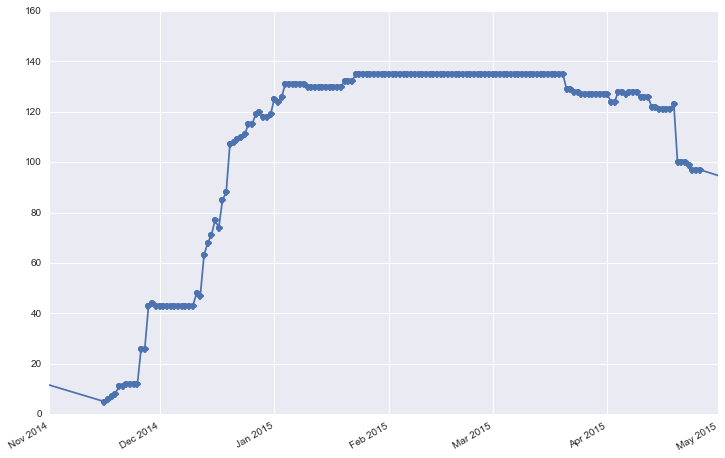

In [26]:
df_all.open_trails.plot(linestyle='-', marker='o', xlim = ['2014-11-1 00:00:00', '2015-05-1 00:00:00'])

#### Delete January 2-6, 2014 (no traffic data).

In [27]:
df_all = pd.concat([df_all.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,1,1)],df_all.ix[datetime.datetime(2015,1,7):datetime.datetime(2016,5,1)]], axis=0)

# Export Data

In [28]:
df_all.to_csv('../data_ski_in_solitude/data_with_features/data_open_trails.csv')